## Importación de librerías

In [1]:
# Procesamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
# -----------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelado y clustering
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Reducción de dimensionalidad
# -----------------------------------------------------------------------
from sklearn.decomposition import PCA

## Carga de datos

In [2]:
df = pd.read_csv('HR_Employee_Attrition_EDA.csv', index_col=0)

df.head()

,Education,EducationField,Gender,MaritalStatus,Age,YearsSinceLastPromotion,YearsWithCurrManager,TotalWorkingYears,NumCompaniesWorked,Country,...,JobLevel,JobRole,MonthlyIncome,OverTime,PercentSalaryHike,TrainingTimesLastYear,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,RelationshipSatisfaction
0,Bachelor,Other,Male,Single,19,0,0,1,1.0,Austria,...,1,Sales Representative,2121,Yes,13,3,Very High,Medium,Medium,Medium
1,College,Technical Degree,Female,Married,30,0,0,4,7.0,España,...,2,Sales Executive,4736,Yes,12,2,Very High,High,High,Medium
2,College,Life Sciences,Male,Single,22,0,0,4,0.0,República Checa,...,1,Research Scientist,3375,No,12,2,Very High,High,High,Very High
3,College,Technical Degree,Male,Married,42,1,5,22,1.0,Misisipi,...,5,Manager,19232,No,11,3,High,High,Very High,Very High
4,Master,Life Sciences,Female,Single,36,0,7,17,3.0,Portugal,...,2,Sales Representative,4502,No,15,2,High,High,Very High,High


## Preproceso

In [3]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No':0})

In [4]:
# Crear una instancia del codificador
encoder = LabelEncoder()

# Ajustar y transformar los datos
for col in df.select_dtypes(include='object').columns:
    df[col] = encoder.fit_transform(df[col])

In [6]:
# Eliminación de valores nulos y duplicados
df = df.drop_duplicates()
df = df.dropna()

In [7]:
# Estandarización
scaler = MinMaxScaler()

df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=scaler.get_feature_names_out())

## Modelo K-Means

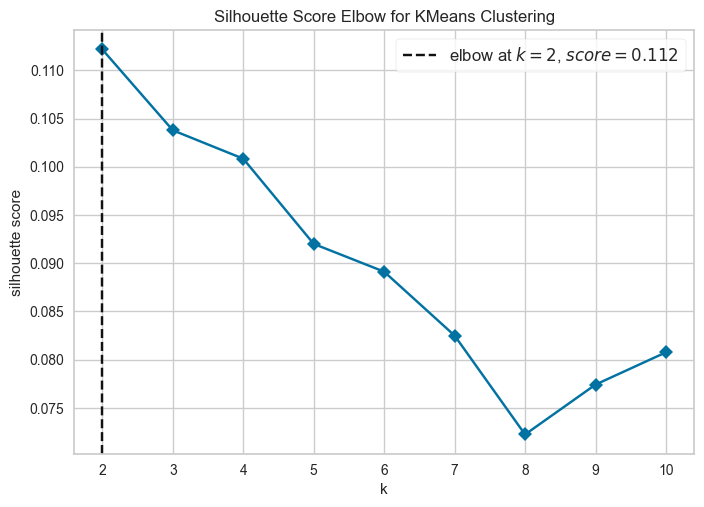

Número óptimo de clusters según Silhouette Score: 2


In [8]:
# Inicializar el modelo K-Means
model = KMeans(random_state=42)

# Aplicar el método del codo con la métrica de Silhouette
visualizer = KElbowVisualizer(model, k=(2, 11), metric='silhouette', timings=False)
visualizer.fit(df)
visualizer.show()

# Obtener el número óptimo de clusters según KElbowVisualizer
optimal_k = visualizer.elbow_value_
print(f"Número óptimo de clusters según Silhouette Score: {optimal_k}")

In [9]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df)
labels = kmeans.labels_

# Agregar etiquetas al DataFrame
df["Cluster"] = labels

## Visualización

In [10]:
df.columns

Index(['Education', 'EducationField', 'Gender', 'MaritalStatus', 'Age',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TotalWorkingYears',
       'NumCompaniesWorked', 'Country', 'Attrition', 'BusinessTravel',
       'Department', 'JobLevel', 'JobRole', 'MonthlyIncome', 'OverTime',
       'PercentSalaryHike', 'TrainingTimesLastYear', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobSatisfaction', 'RelationshipSatisfaction',
       'Cluster'],
      dtype='object')

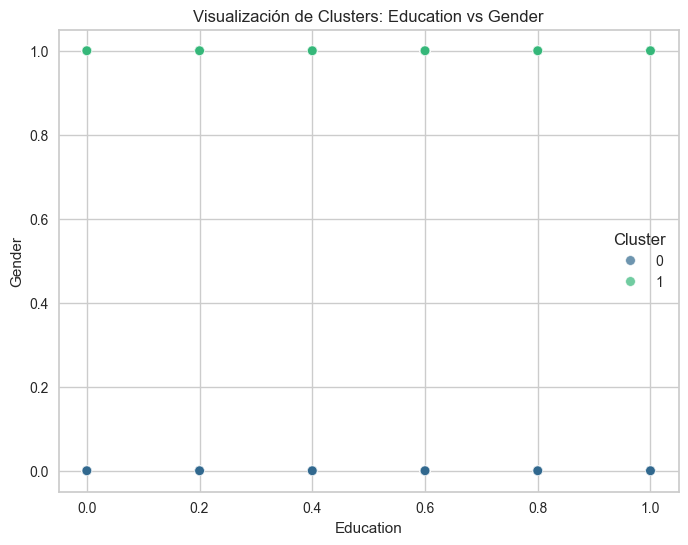

In [13]:
# Seleccionar dos características
feature_x = 'Education'
feature_y = 'Gender'

# Graficar los clusters en función de estas dos variables
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x=feature_x, y=feature_y, hue="Cluster", palette="viridis", alpha=0.7)
plt.title(f"Visualización de Clusters: {feature_x} vs {feature_y}")
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title="Cluster")
plt.show()

## Reducción de la dimensionalidad

In [14]:
# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=["Cluster"]))

# Convertir en DataFrame para Seaborn
df_pca = df.copy()
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]

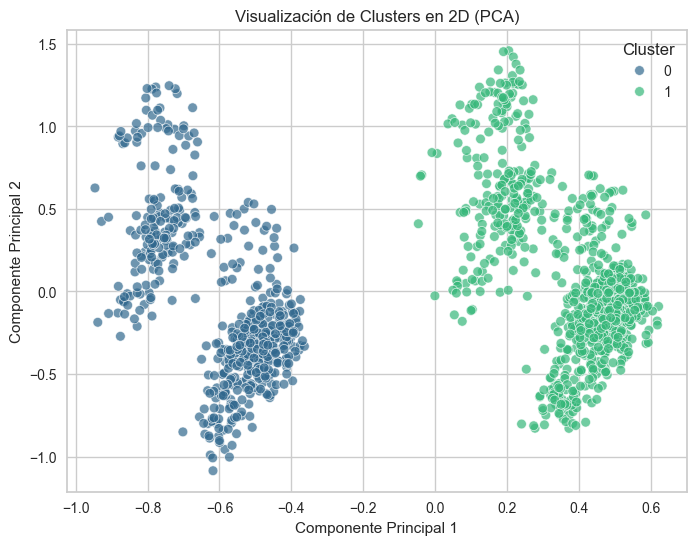

In [15]:
# Graficar los clusters en 2D
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="viridis", alpha=0.7)

# Etiquetas y título
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de Clusters en 2D (PCA)")
plt.legend(title="Cluster")
plt.show()

## Correlación

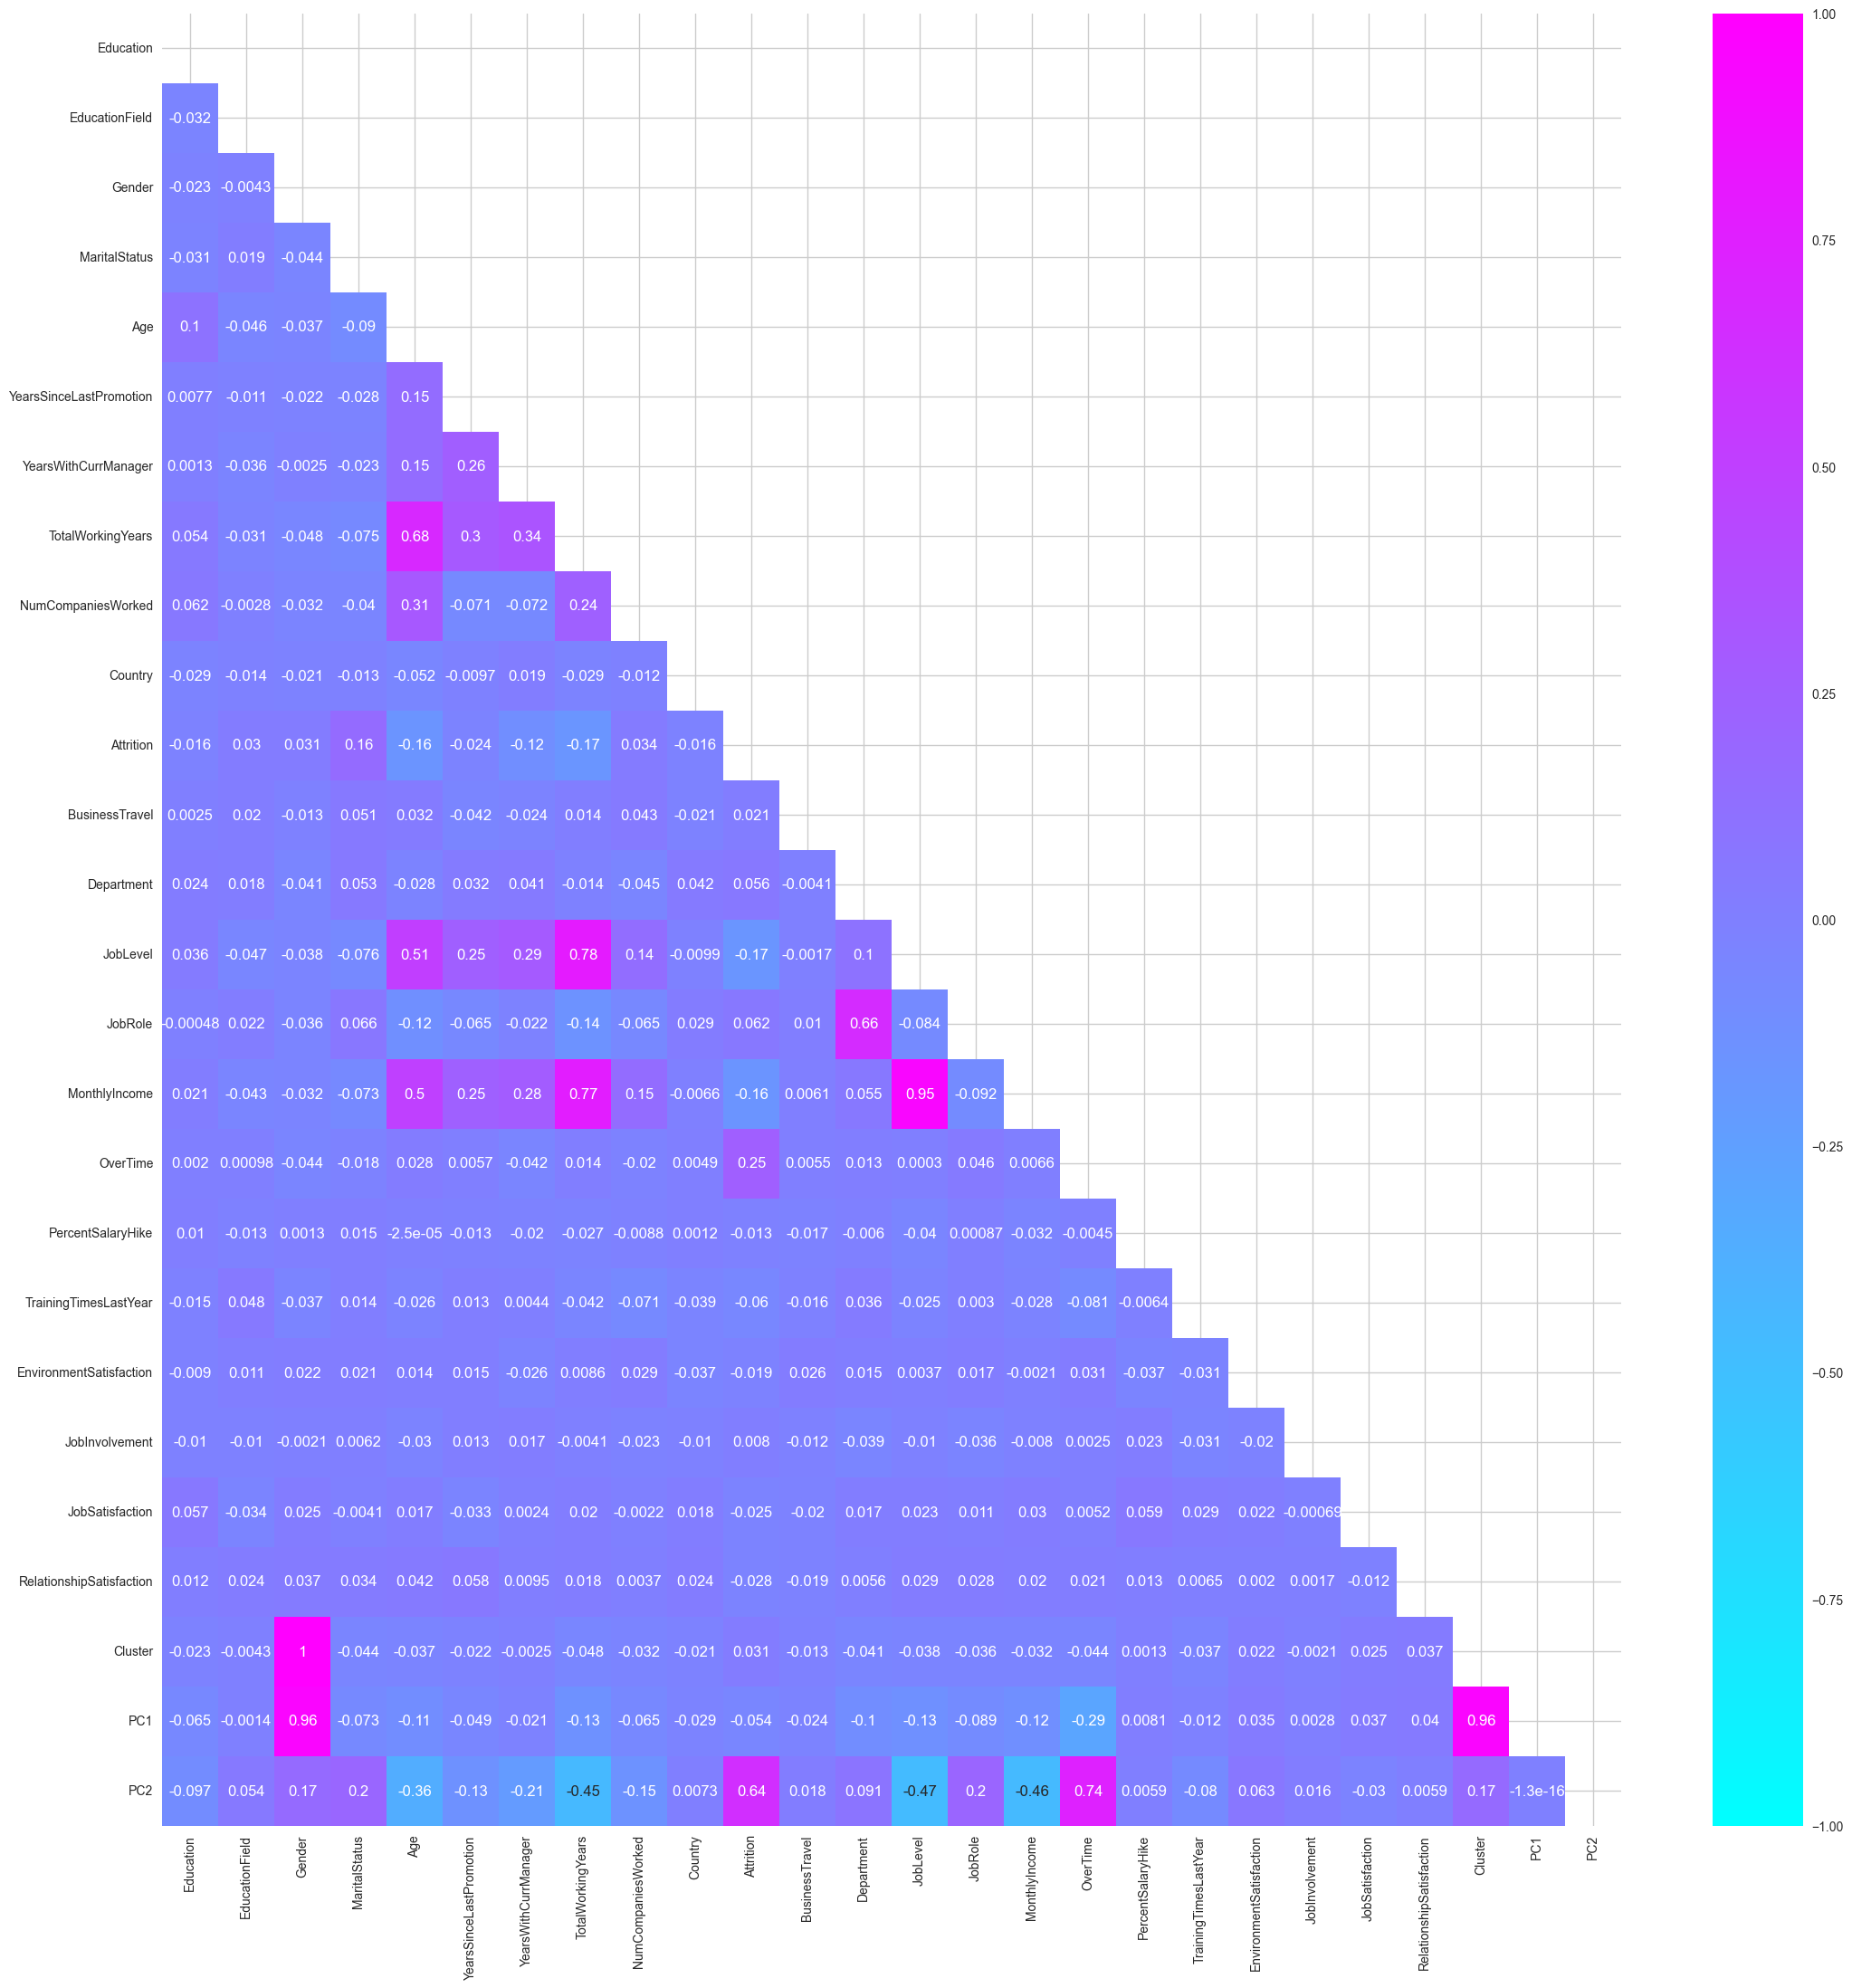

In [16]:
# Calculamos la matriz de correlación
corr = df_pca.corr()

# Creamos una máscara para la parte superior de la matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configuramos el tamaño del gráfico
n = corr.shape[1]
plt.figure(figsize=(n, n))

# Dibujamos el mapa de calor con la máscara
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='cool')

# Mostramos el gráfico
plt.show()

# Nuevo modelo con componentes principales

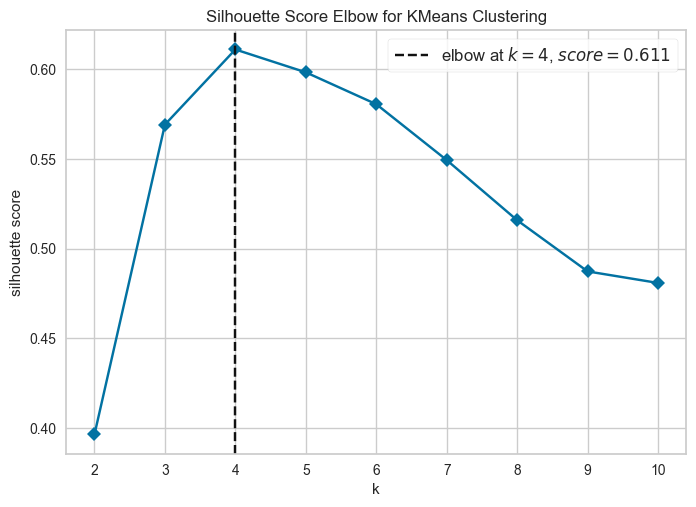

Número óptimo de clusters según Silhouette Score: 4


In [17]:
df_new = df_pca[['PC1', 'PC2']].copy()

# Inicializar el modelo K-Means
model = KMeans(random_state=42)

# Aplicar el método del codo con la métrica de Silhouette
visualizer = KElbowVisualizer(model, k=(2, 11), metric='silhouette', timings=False)
visualizer.fit(df_new)
visualizer.show()

# Obtener el número óptimo de clusters según KElbowVisualizer
optimal_k = visualizer.elbow_value_
print(f"Número óptimo de clusters según Silhouette Score: {optimal_k}")

## Modelo K-Means

In [18]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_new)
labels = kmeans.labels_

# Agregar etiquetas al DataFrame
df_new["Cluster"] = labels

## Nuevos clusters

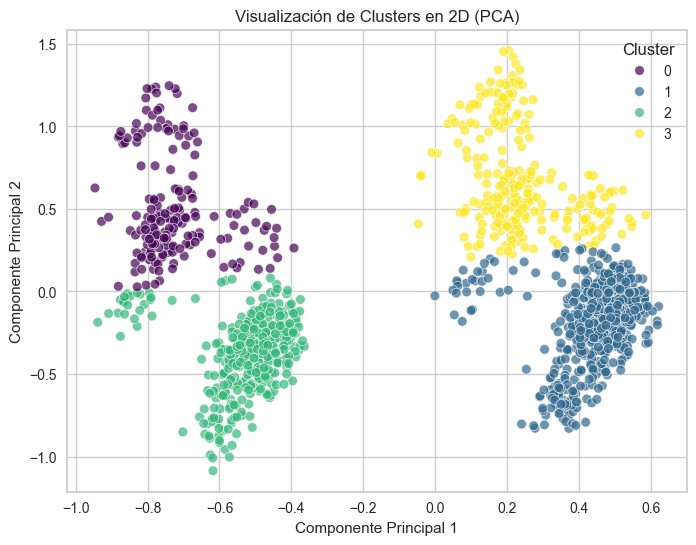

In [19]:
# Graficar los clusters en 2D
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_new, x="PC1", y="PC2", hue="Cluster", palette="viridis", alpha=0.7)

# Etiquetas y título
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de Clusters en 2D (PCA)")
plt.legend(title="Cluster")
plt.show()

## Comparación de clusters

In [20]:
# Añadimos las nuevas etiquetas de los 4 clusters
df_pca['Cluster'] = df_new['Cluster']

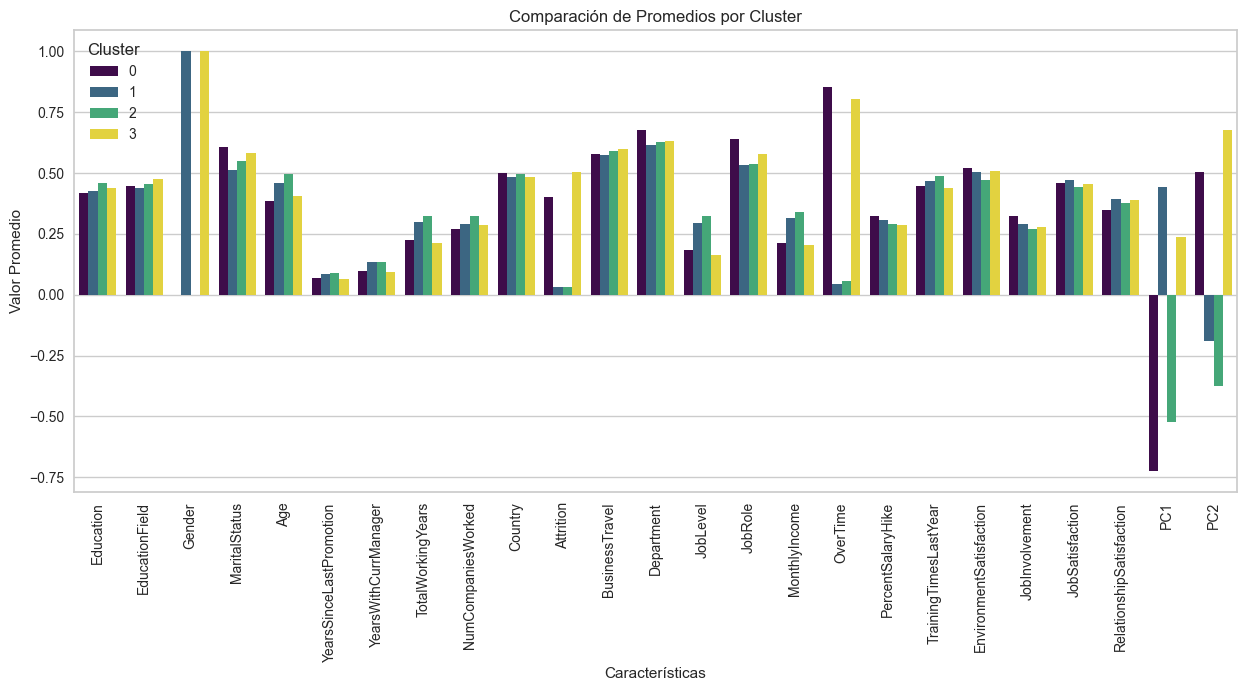

In [23]:
# Calcular los promedios por cluster
cluster_means = df_pca.groupby("Cluster").mean()

# Convertir a formato largo (melt) para Seaborn
df_melted = cluster_means.reset_index().melt(id_vars="Cluster", var_name="Características", value_name="Valor Promedio")

plt.figure(figsize=(15,6))
sns.barplot(data=df_melted, x="Características", y="Valor Promedio", hue="Cluster", palette="viridis")

plt.title("Comparación de Promedios por Cluster")
plt.xlabel("Características")
plt.ylabel("Valor Promedio")
plt.legend(title="Cluster")
plt.xticks(rotation=90)
plt.show()

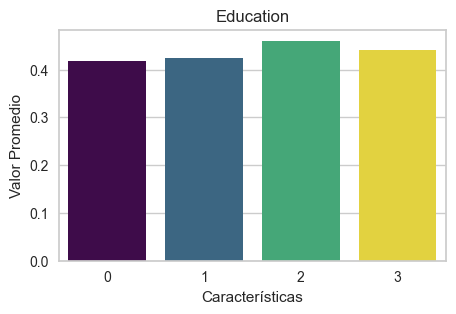

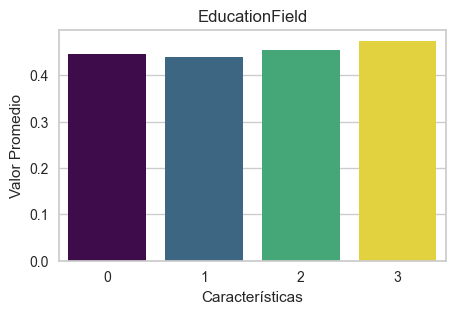

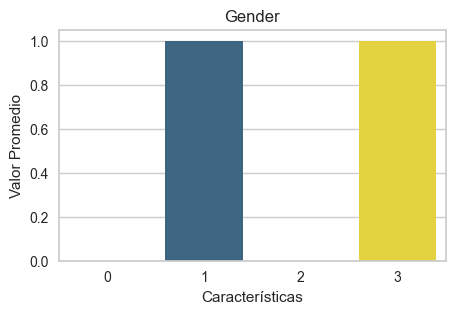

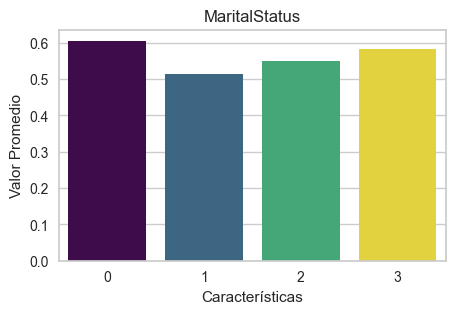

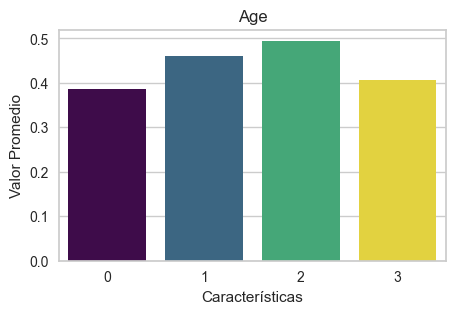

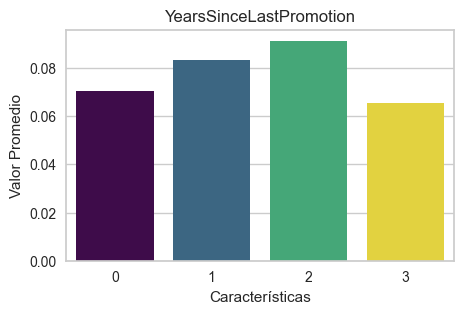

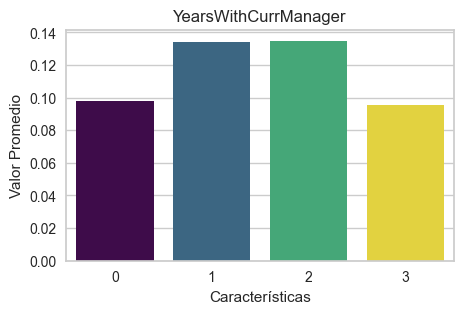

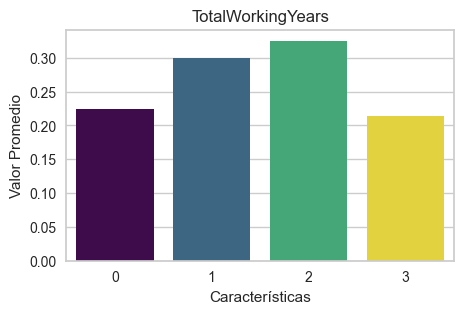

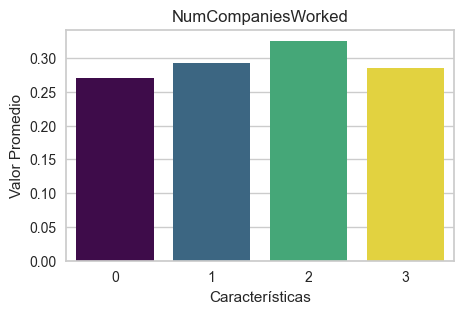

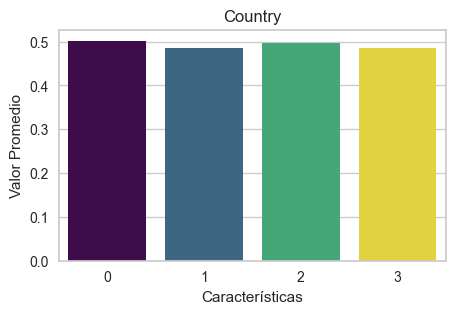

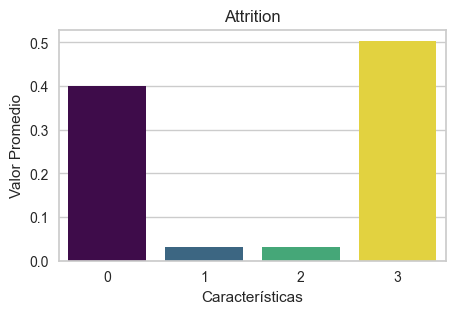

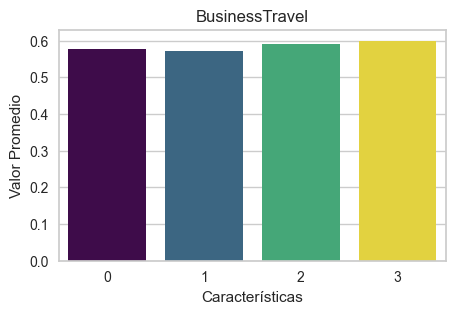

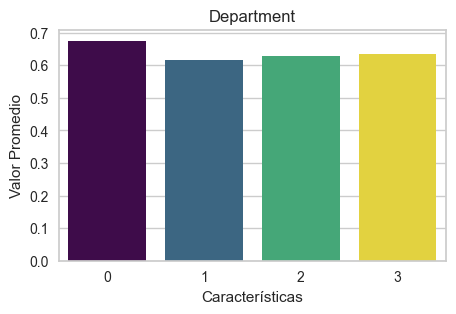

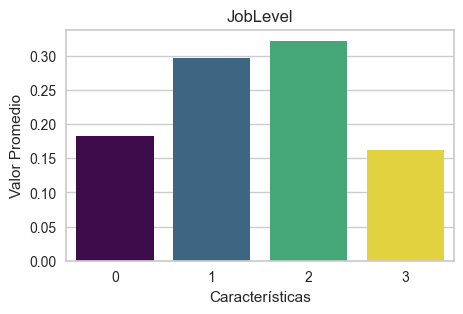

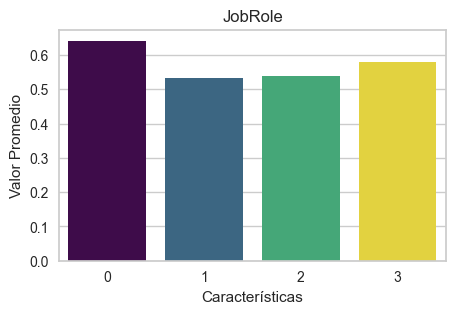

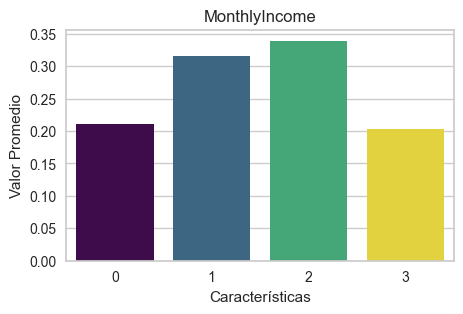

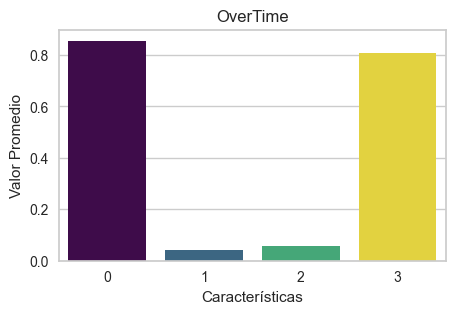

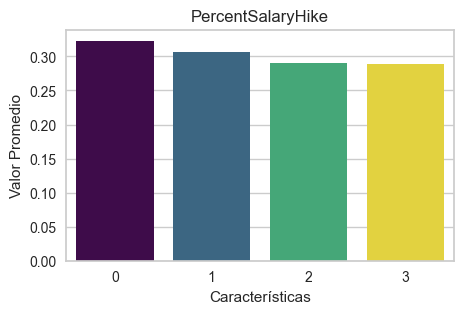

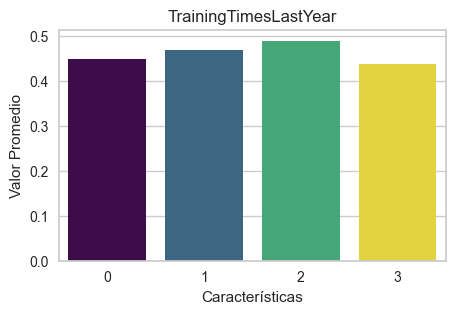

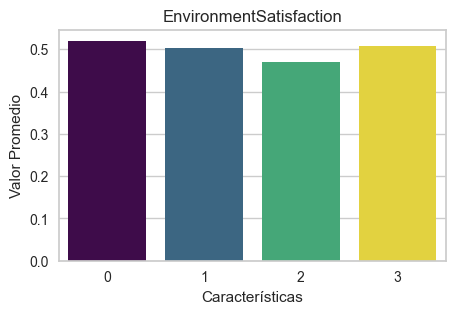

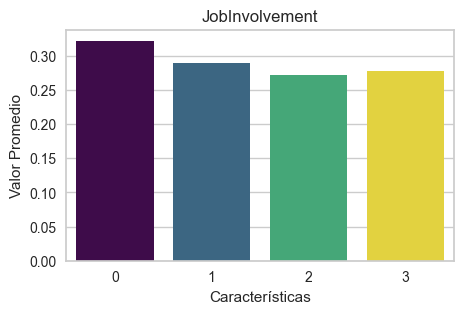

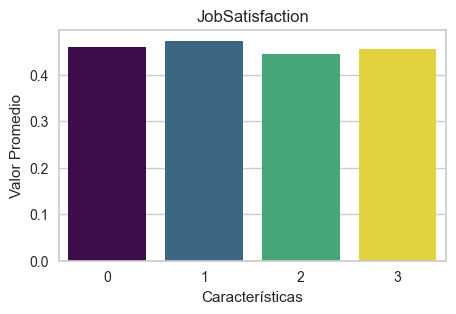

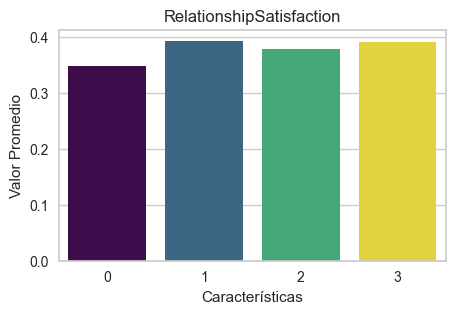

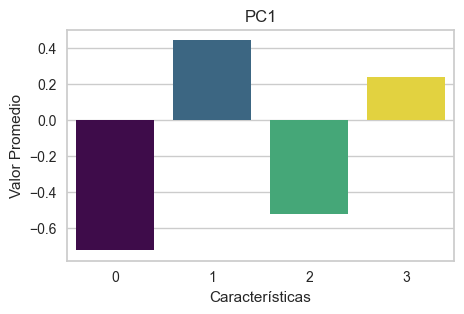

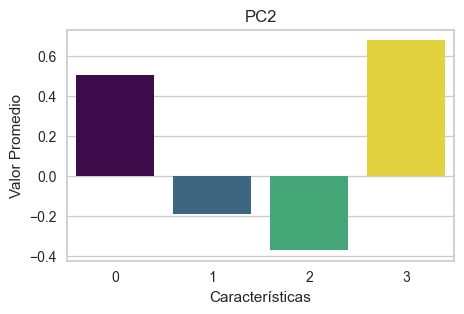

In [26]:
for col in cluster_means.columns.to_list():

    plt.figure(figsize=(5,3))
    sns.barplot(data=cluster_means, x="Cluster", y=col, hue="Cluster", palette="viridis", legend=False)

    plt.title(col)
    plt.xlabel("Características")
    plt.ylabel("Valor Promedio")
    plt.show()